# **CS909/CS429 Data Mining 2023 Assignment 1: Classification**

In [96]:
import numpy as np 
import pandas as pd
# To generate random numbers
import random
# For plotting
import matplotlib.pyplot as plt
# For performance metrics
from sklearn.metrics import accuracy_score,balanced_accuracy_score,roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
# For classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# For tables
from tabulate import tabulate
# To reduce dimensions
from sklearn.decomposition import PCA
# For optimization
from sklearn.model_selection import GridSearchCV 
# For dataframes
from pandas import DataFrame 
# For train/test splits
from sklearn.model_selection import train_test_split 
# Feature selector
from sklearn.feature_selection import VarianceThreshold 
# For setting up pipeline
from sklearn.pipeline import Pipeline 
# Various pre-processing steps
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder


## Question 1

In [66]:
# loading the datasets
xtest=np.loadtxt('Xtest.csv')
xtrain=np.loadtxt('Xtrain.csv')
ytrain=np.loadtxt('Ytrain.csv')

### (i) How many training and test examples are there? How many positive and negative examples are there in the training dataset?

In [67]:
# number of training and test examples
a=np.shape(xtest)
b=np.shape(xtrain)
c=np.shape(ytrain)
print("X test examples:", a)
print("X train examples:", b)
print("Y train examples:", c)

X test examples: (3000, 784)
X train examples: (3000, 784)
Y train examples: (3000,)


In [68]:
# number of positives and negatives in the Y training dataset
positives_ytrain=(ytrain>0).sum()
negatives_ytrain=(ytrain<0).sum()
print("Positives in the Y training dataset:", positives_ytrain)
print("Negatives in the Y training dataset:", negatives_ytrain)

Positives in the Y training dataset: 611
Negatives in the Y training dataset: 2389


### A. There are 3000 examples in the training and test datasets. There are 611 positive examples and 2389 negative examples in the Y training dataset.

### (ii) Show at least 10 randomly selected objects of each class using plt.matshow by reshaping the flattened array to 28x28. What are your observations about the nature of the data? Also show 10 randomly selected objects from the test set. Do you see any issues in the data that may limit the generalization performance of your classifier?


In [69]:
# making a list of positive and negative objects
positive_list=[]
negative_list=[]
for i, numers in enumerate(ytrain):
    if numers==1:
        positive_list.append(i)
    else:
        negative_list.append(i) 

In [70]:
# selecting 10 random positive and negative objects
positive_random=random.sample(positive_list, 10)
negative_random=random.sample(negative_list, 10)

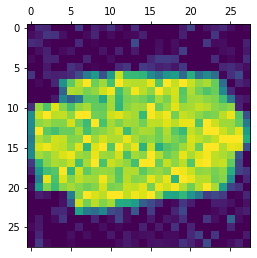

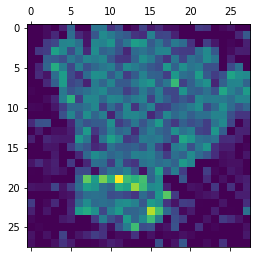

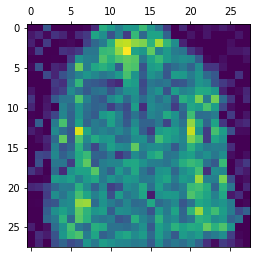

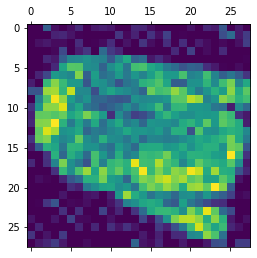

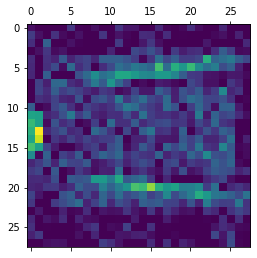

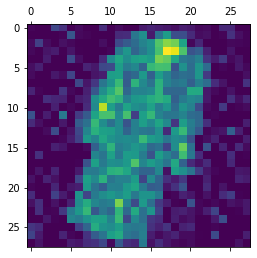

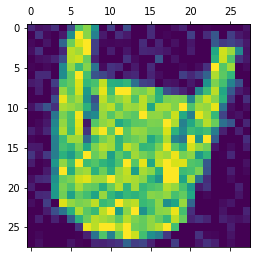

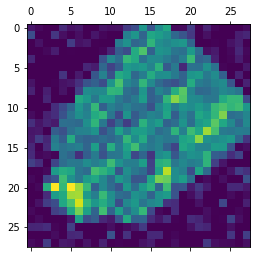

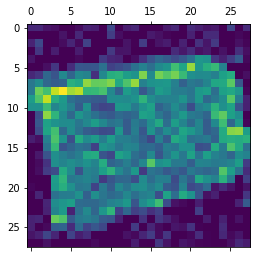

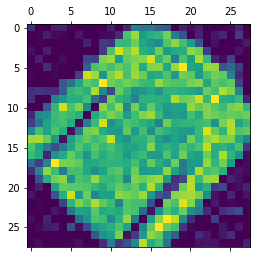

In [71]:
# plotting 10 randomly selected positive objects and reshaping the flattened array to 28x28
for i in positive_random:
    plt.matshow(xtrain[i].reshape(28,28))

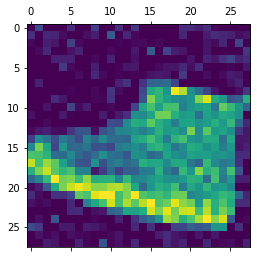

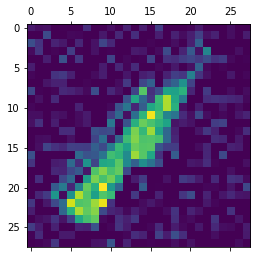

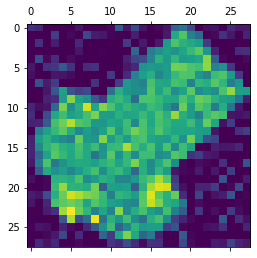

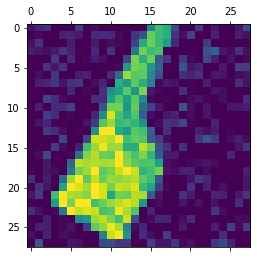

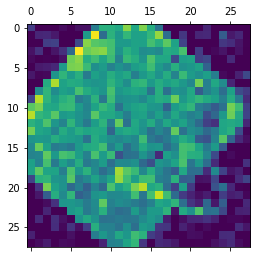

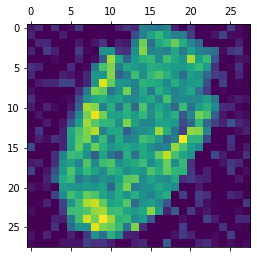

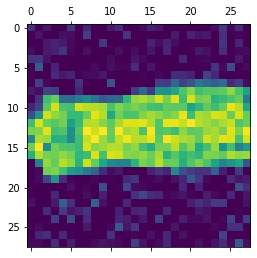

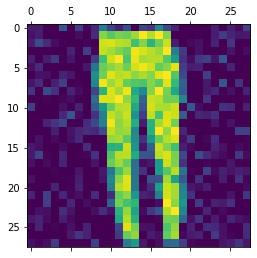

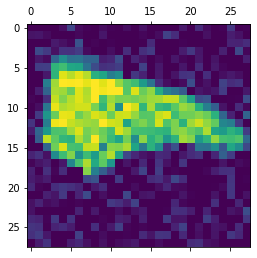

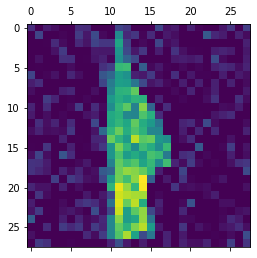

In [72]:
# plotting 10 randomly selected negative objects and reshaping the flattened array to 28x28
for i in negative_random:
    plt.matshow(xtrain[i].reshape(28,28))

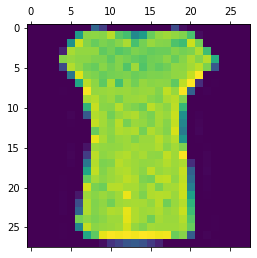

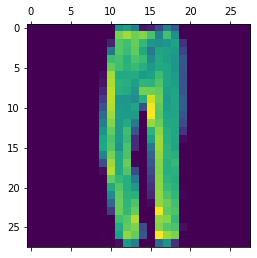

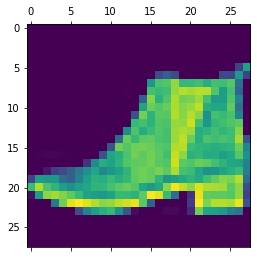

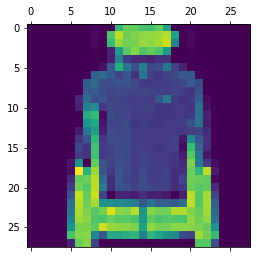

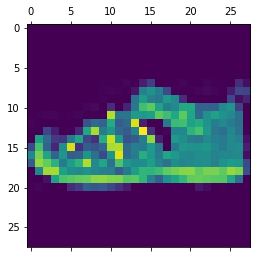

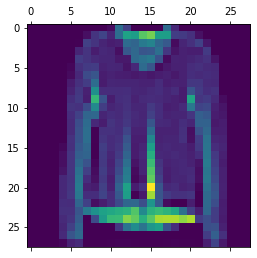

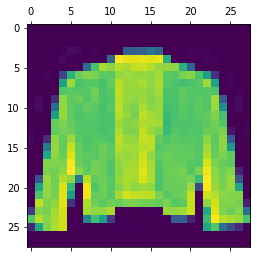

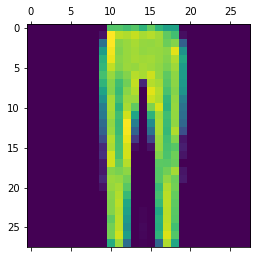

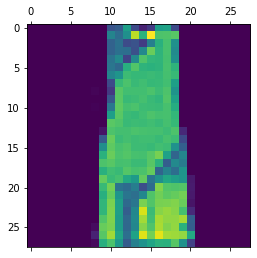

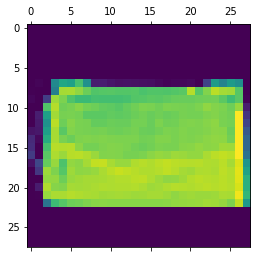

In [73]:
# selecting and plotting 10 randomly selected objects from the test dataset and reshaping the flattened array to 28x28
randomRow = np.random.randint(3000,size=10)
randomRow
for i in randomRow:
    plt.matshow(xtest[i].reshape(28,28))

### A. The randomly selected objects in the test dataset are straighter and clearer compared to the randomly selected objects in the training data. This may limit the generalization performance of our classifier.

### (iii) Which performance metric (e.g., accuracy, AUC-ROC and AUC-PR) should be used for this problem? Give the reasoning behind your choice(s).

### A. AUC-PR should be used for this problem because the dataset is unbalanced. Accuracy can lead to incorrect conclusions about the performance of the classifier in a dataset that is unbalanced. ROC curves are also applicable when there is a balanced number of observations for each class. Hence, precision-recall curves are suitable for datasets that are unbalanced.

### (iv) What is the expected accuracy of a random classifier (one that generates random labels for a given example) for this problem over the training and test datasets? Demonstrate (either by a mathematical or statistical proof or a programming experiment) why this would be the case.

In [74]:
# test predicitions

accuracy_list=[]

# random values between 0 to 1
random_values=np.random.rand(3000) 
threshold=0.5

# assigning labels -1 and +1 to the random values
for i in random_values:
    if i<0.5:
        a=-1
    else:
        a=+1
    accuracy_list.append(a)

expected_accuracy=accuracy_score(ytrain,accuracy_list)
print('Expected accuracy of a random classifier:',expected_accuracy)

Expected accuracy of a random classifier: 0.503


### A. The expected accuracy of the random classifier is about 50% and we have proved it using a programming experiment.

### (v) What is the AUC-ROC and AUC-PR of a random classifier for this problem over the training and test datasets? Demonstrate (either by a mathematical or statistical proof or a programming experiment) why this would be the case.

In [75]:
# function for AUC-ROC
def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title('ROC '+pstr+' AUC: '+str(roc_auc))
    return roc_auc

# function for AUC-PR
def plotPRC(y,z,pstr = ''):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    plt.figure()
    plt.plot(R,P,'o-');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.title('PRC '+pstr+' AUC: '+str(pr_auc))
    return pr_auc

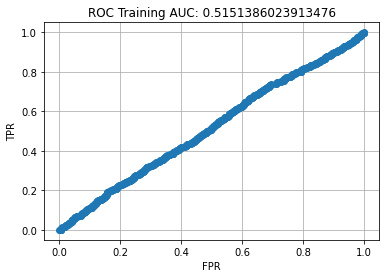

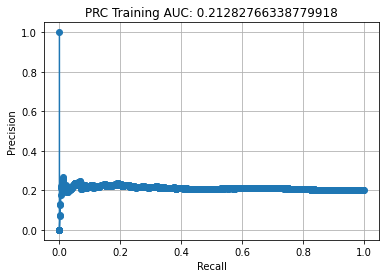

In [76]:
# AUC-ROC plot
roc_tr = plotROC(ytrain,random_values,'Training')

# AUC-PR plot
pr_tr = plotPRC(ytrain,random_values,'Training')

### A. The closer the AUC is to 1, the better is the model.
### The AUC-ROC of a random classifier for this problem is about 0.5 and the AUC-PR of a random classifier for this problem is about 0.2. Hence, the model is not a good fit. We have proved it with a programming experiment.

## Question 2

### (i) What is the accuracy, balanced accuracy, AUC-ROC and AUC-PR for each fold using this classifier? Show code to demonstrate the results. Calculate the average and standard deviation for each metric across all folds and show these in a single table. As the KNN classifier in sklearn does not support decision_function, be sure to understand and use the predict_proba function for AUC-ROC and AUC-PR calculations or plotting.

In [77]:
# fitting the data to 5-fold stratified cross validation
skf = StratifiedKFold(n_splits=5,shuffle = True)   

In [78]:
# Accuracy

A=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    predict_accuracy=sknn.predict(Xv)
    
    # accuracy
    accuracy=accuracy_score(yv,predict_accuracy)
    A.append(accuracy)
    print('Fold ',i,'Accuracy:',accuracy)

print('Fold-Wise Accuracy',A)

# mean accuracy
mean_a=np.mean(A)

# standard deviation accuracy
stdev_a=np.std(A)

Fold  0 Accuracy: 0.87
Fold  1 Accuracy: 0.87
Fold  2 Accuracy: 0.8683333333333333
Fold  3 Accuracy: 0.8816666666666667
Fold  4 Accuracy: 0.8716666666666667
Fold-Wise Accuracy [0.87, 0.87, 0.8683333333333333, 0.8816666666666667, 0.8716666666666667]


In [79]:
# Balanced Accuracy

BA=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    predict_balanced=sknn.predict(Xv)
    
    # balanced accuracy
    accuracy_balanced=balanced_accuracy_score(yv,predict_balanced)
    BA.append(accuracy_balanced)
    print('Fold ',i,'Balanced Accuracy:',accuracy_balanced)
    
print('Fold-Wise Balanced Accuracy',BA)

# mean balanced accuracy
mean_ba=np.mean(BA)

# standard deviation balanced accuracy
stdev_ba=np.std(BA)

Fold  0 Balanced Accuracy: 0.7935215035324783
Fold  1 Balanced Accuracy: 0.8024212908978667
Fold  2 Balanced Accuracy: 0.7984944097674738
Fold  3 Balanced Accuracy: 0.7974483846628713
Fold  4 Balanced Accuracy: 0.8152835301937924
Fold-Wise Balanced Accuracy [0.7935215035324783, 0.8024212908978667, 0.7984944097674738, 0.7974483846628713, 0.8152835301937924]


In [80]:
# AUC-ROC

ROC=[]
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    
    # predicitions using predict proba
    predict=sknn.predict_proba(Xv)
    
    # AUC-ROC
    fpr,tpr,tt=roc_curve(yv,predict[:,1])
    roc_auc = auc(fpr,tpr)
    ROC.append(roc_auc)
    print('Fold ',i,'AUC ROC:',roc_auc)
    
print('Fold-Wise AUC-ROC',ROC)

# mean AUC-ROC
mean_roc=np.mean(ROC)

# standard deviation AUC-ROC
stdev_roc=np.std(ROC)

Fold  0 AUC ROC: 0.8910590575485288
Fold  1 AUC ROC: 0.8963663488579463
Fold  2 AUC ROC: 0.8896529254407023
Fold  3 AUC ROC: 0.8672148295493518
Fold  4 AUC ROC: 0.8832302159499583
Fold-Wise AUC-ROC [0.8910590575485288, 0.8963663488579463, 0.8896529254407023, 0.8672148295493518, 0.8832302159499583]


In [81]:
# AUC-PR

PR=[]
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
   
    # predicitions using predict proba
    predict=sknn.predict_proba(Xv)
    

    # AUC-PR
    pr_auc = average_precision_score(yv,predict[:,1])
    PR.append(pr_auc)
    print('Fold ',i,'AUC PRC:',pr_auc)


print('Fold-Wise AUC-PR',PR)

# mean AUC-ROC
mean_pr=np.mean(PR)

# standard deviation AUC-PR
stdev_pr=np.std(PR)

Fold  0 AUC PRC: 0.672793427230047
Fold  1 AUC PRC: 0.709262919427575
Fold  2 AUC PRC: 0.583499253791779
Fold  3 AUC PRC: 0.5502825680694533
Fold  4 AUC PRC: 0.7064464292530248
Fold-Wise AUC-PR [0.672793427230047, 0.709262919427575, 0.583499253791779, 0.5502825680694533, 0.7064464292530248]


In [82]:
# average and standard deviation of each performance metrics in a table 

table=[['Performance Metrics', 'Mean','Standard Deviation'],
        ['Accuracy',mean_a,stdev_a],
        ['Balanced Accuracy',mean_ba,stdev_ba],
        ['AUC-ROC',mean_roc,stdev_roc],
        ['AUC-PR',mean_pr,stdev_pr]]

print(tabulate(table,headers='firstrow',tablefmt='grid',showindex=range(1,5)))

+----+-----------------------+----------+----------------------+
|    | Performance Metrics   |     Mean |   Standard Deviation |
+====+=======================+==========+======================+
|  1 | Accuracy              | 0.872333 |           0.00478423 |
+----+-----------------------+----------+----------------------+
|  2 | Balanced Accuracy     | 0.801434 |           0.00748222 |
+----+-----------------------+----------+----------------------+
|  3 | AUC-ROC               | 0.885505 |           0.0100571  |
+----+-----------------------+----------+----------------------+
|  4 | AUC-PR                | 0.644457 |           0.0654677  |
+----+-----------------------+----------+----------------------+


### (ii) Plot the ROC and PR curves for one fold. What are your observations about the ROC and PR curves?

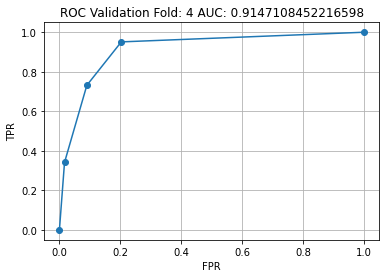

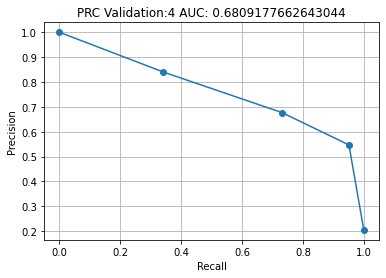

In [83]:
# ROC and PR curve

ROC=[]
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    
    # predicitions using predict proba
    predict=sknn.predict_proba(Xv)

# ROC curve
roc_curve = plotROC(yv,predict[:,1],pstr = 'Validation Fold: '+str(i))

#PR curve
pr_curve = plotPRC(yv,predict[:,1],'Validation:' +str(i))

### A. The closer the area under the curve to 1, the better it the model. 
### For ROC curve, since the area under the curve is close to 1, (0.8733), it indicates that the model is making good predicitions.
### For PR curve, since the area under the curve is close to 1, (0.8733), it indicates that the model is not making good predicitions in terms of the precision-recall curve.

### (iii) What is the impact of various forms of pre-processing (https://scikit-learn.org/stable/modules/preprocessing.html ) (e.g., mean-standard deviation or standard scaling or min-max scaling) on the cross-validation performance? Show code to demonstrate the results and write a summary of your findings. Do any pre-processing techniques improve predictive performance? Why do you think this is the case?

In [84]:
# Min-Max Scaler

MM_A=[]
MM_BA=[]
MM_ROC=[]
MM_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    predict_mm=sknn.predict(Xv)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    Xv_minmax = min_max_scaler.fit_transform(Xv)
    Xtr_minmax = min_max_scaler.fit_transform(Xtr)
    
    
    # Accuracy
    mm_accuracy=accuracy_score(yv,predict_mm)
    MM_A.append(mm_accuracy)
    
    # Balanced Accuracy
    mm_balanced=balanced_accuracy_score(yv,predict_mm)
    MM_BA.append(mm_balanced)
    
    # ROC
    roc_mm=roc_auc_score(yv,predict_mm)
    MM_ROC.append(roc_mm)
    
    # PR
    pr_mm= average_precision_score(yv,predict_mm)
    MM_PR.append(pr_mm)

# Mean Accuracy
mean_a_mm=np.mean(MM_A)
print('Accuracy:',np.mean(MM_A))

# Std Dev Accuracy                         
stdev_a_mm=np.std(MM_A)
print('Std Dev Accuracy:',np.std(MM_A))

# Mean Balanced Accuracy                        
mean_ba_mm=np.mean(MM_BA)
print('Balanced Accuracy:',np.mean(MM_BA))

# Std Dev Balanced Accuracy                         
stdev_ba_mm=np.std(MM_BA)
print('Std Dev Balanced Accuracy:',np.std(MM_BA))

# Mean ROC
mean_roc_mm=np.mean(MM_ROC)
print('Mean ROC:',np.mean(MM_ROC))

# Std Dev ROC                         
stdev_roc_mm=np.std(MM_ROC)
print('Std Dev ROC:',np.std(MM_ROC))

# Mean PR
mean_pr_mm=np.mean(MM_PR)
print('Mean PR:',np.mean(MM_PR))

# Std Dev PR
stdev_pr_mm=np.std(MM_PR)
print('Std Dev PR:',np.std(MM_PR))

Accuracy: 0.8716666666666667
Std Dev Accuracy: 0.00380058475033046
Balanced Accuracy: 0.8024603240815548
Std Dev Balanced Accuracy: 0.017283368915167567
Mean ROC: 0.8024603240815548
Std Dev ROC: 0.017283368915167564
Mean PR: 0.5338995601489138
Std Dev PR: 0.014089810914927526


In [85]:
# Standard Scaler

SS_A=[]
SS_BA=[]
SS_ROC=[]
SS_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    predict_ss=sknn.predict(Xv)
    
    standard_scaler = preprocessing.StandardScaler()
    Xv_stds = standard_scaler.fit_transform(Xv)
    Xtr_std = standard_scaler.fit_transform(Xtr)
    
    # Accuracy
    ss_accuracy=accuracy_score(yv,predict_ss)
    SS_A.append(ss_accuracy)
    
    # Balanced Accuracy
    ss_balanced=balanced_accuracy_score(yv,predict_ss)
    SS_BA.append(ss_balanced)
    
    # ROC
    roc_ss=roc_auc_score(yv,predict_ss)
    SS_ROC.append(roc_ss)
    
    # PR
    pr_ss= average_precision_score(yv,predict_ss)
    SS_PR.append(pr_ss)

# Mean Accuracy
mean_a_ss=np.mean(SS_A)
print('Accuracy:',np.mean(SS_A))

# Std Dev Accuracy                         
stdev_a_ss=np.std(SS_A)
print('Std Dev Accuracy:',np.std(SS_A))

# Mean Balanced Accuracy                        
mean_ba_ss=np.mean(SS_BA)
print('Balanced Accuracy:',np.mean(SS_BA))

# Std Dev Balanced Accuracy                         
stdev_ba_ss=np.std(SS_A)
print('Std Dev Balanced Accuracy:',np.std(SS_A))

# Mean ROC
mean_roc_ss=np.mean(SS_ROC)
print('Mean ROC:',np.mean(SS_ROC))

# Std Dev ROC                         
stdev_roc_ss=np.std(SS_ROC)
print('Std Dev ROC:',np.std(SS_ROC))

# Mean PR
mean_pr_ss=np.mean(SS_PR)
print('Mean PR:',np.mean(SS_PR))

# Std Dev PR
stdev_pr_ss=np.std(SS_PR)
print('Std Dev PR:',np.std(SS_PR))

Accuracy: 0.8640000000000001
Std Dev Accuracy: 0.010624918300339483
Balanced Accuracy: 0.7861300548769904
Std Dev Balanced Accuracy: 0.010624918300339483
Mean ROC: 0.7861300548769905
Std Dev ROC: 0.018242116071324213
Mean PR: 0.5102831745964058
Std Dev PR: 0.028077981190864687


In [86]:
# Mean Standard Deviation

MS_A=[]
MS_BA=[]
MS_ROC=[]
MS_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    sknn = KNeighborsClassifier(n_neighbors=3)
    sknn.fit(Xtr,ytr)
    predict_ms=sknn.predict(Xv)
    
    Xv_ms = (Xv-Xv.mean())/Xv.std()
    Xtr_ms = (Xtr-Xtr.mean())/Xtr.std()
    
    # Accuracy
    ms_accuracy=accuracy_score(yv,predict_ms)
    MS_A.append(ms_accuracy)
    
    # Balanced Accuracy
    ms_balanced=balanced_accuracy_score(yv,predict_ms)
    MS_BA.append(ms_balanced)
    
    # ROC
    roc_ms=roc_auc_score(yv,predict_ms)
    MS_ROC.append(roc_ms)
    
    # PR
    pr_ms= average_precision_score(yv,predict_ms)
    MS_PR.append(pr_ms)

# Mean Accuracy
mean_a_ms=np.mean(MS_A)
print('Accuracy:',np.mean(MS_A))

# Std Dev Accuracy                         
stdev_a_ms=np.std(MS_A)
print('Std Dev Accuracy:',np.std(MS_A))

# Mean Balanced Accuracy                        
mean_ba_ms=np.mean(MS_BA)
print('Balanced Accuracy:',np.mean(MS_BA))

# Std Dev Balanced Accuracy                         
stdev_ba_ms=np.std(MS_BA)
print('Std Dev Accuracy:',np.std(MS_BA))

# Mean ROC
mean_roc_ms=np.mean(MS_ROC)
print('Mean ROC:',np.mean(MS_ROC))

# Std Dev ROC                         
stdev_roc_ms=np.std(MS_ROC)
print('Std Dev ROC:',np.std(MS_ROC))

# Mean PR
mean_pr_ms=np.mean(MS_PR)
print('Mean PR:',np.mean(MS_PR))

# Std Dev PR
stdev_pr_ms=np.std(MS_PR)
print('Std Dev PR:',np.std(MS_PR))

Accuracy: 0.8723333333333333
Std Dev Accuracy: 0.016619934483090557
Balanced Accuracy: 0.8041346574621558
Std Dev Accuracy: 0.026025936756225086
Mean ROC: 0.8041346574621558
Std Dev ROC: 0.026025936756225054
Mean PR: 0.538004813267295
Std Dev PR: 0.04805476043713294


In [87]:
# Consolidated table of the various forms of pre-processing

print(tabulate({'Forms of Pre-Processing':['Min-Max','Min-Max','Min-Max','Min-Max',
                                           'Standard Scaler','Standard Scaler','Standard Scaler','Standard Scaler',
                                           'Mean Standard Deviation','Mean Standard Deviation','Mean Standard Deviation','Mean Standard Deviation'],
                'Performance Metrics': ['Accuracy', 'Balanced Accuracy','ROC','PR',
                                       'Accuracy', 'Balanced Accuracy','ROC','PR',
                                       'Accuracy', 'Balanced Accuracy','ROC','PR'], 
                'Mean': [mean_a_mm,mean_ba_mm,mean_roc_mm,mean_pr_mm,
                         mean_a_ss,mean_ba_ss,mean_roc_ss,mean_pr_ss,
                         mean_a_ms,mean_ba_ms,mean_roc_ms,mean_pr_ms], 
                'Standard Deviation': [stdev_a_mm,stdev_ba_mm,stdev_roc_mm,stdev_pr_mm,
                                       stdev_a_ss,stdev_ba_ss,stdev_roc_ss,stdev_pr_ss,
                                       stdev_a_ms,stdev_ba_ms,stdev_roc_ms,stdev_pr_ms]}, 
                headers='keys', 
                tablefmt='fancy_grid'))

╒═══════════════════════════╤═══════════════════════╤══════════╤══════════════════════╕
│ Forms of Pre-Processing   │ Performance Metrics   │     Mean │   Standard Deviation │
╞═══════════════════════════╪═══════════════════════╪══════════╪══════════════════════╡
│ Min-Max                   │ Accuracy              │ 0.871667 │           0.00380058 │
├───────────────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Min-Max                   │ Balanced Accuracy     │ 0.80246  │           0.0172834  │
├───────────────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Min-Max                   │ ROC                   │ 0.80246  │           0.0172834  │
├───────────────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Min-Max                   │ PR                    │ 0.5339   │           0.0140898  │
├───────────────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Standard Scaler           │ Ac

### A. We performed 3 pre-processing techniques- min-max, standard scaling, mean-standard deviation and observe that the performance metrics for all 3 are. similar. The mean standard deviation is better by 0.01%.
### We first use the MinMax Scaler wherein the feature values of the testing and training sets are independently normalised. Secondly, we use a StandardScaler is used to standardize the feature values of the testing and training sets separately. Lastly we use the MeanStandardised Scaling wherein the feature values of the testing and training sets are standardized using their mean and standard deviation

## Question 3

### Use 5-fold stratified cross-validation over training data to choose an optimal classifier between: Perceptron, Naïve Bayes Classifier, Linear SVM and Kernelized SVM. Be sure to tune the hyperparameters of each classifier type (C and kernel type and kernel hyper-parameters for SVM etc). Report the cross validation results (mean and standard deviation of accuracy, balanced accuracy, AUC-ROC and AUC-PR across fold) of your best model. You may look into grid search as well as ways of pre-processing data.


In [88]:
# Fitting the data to 5-fold stratified cross validation

skf = StratifiedKFold(n_splits=5,shuffle = True)   

In [89]:
# Perceptron

P_A=[]
P_BA=[]
P_ROC=[]
P_PR=[]


for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    knn = Perceptron(eta0=0.1,random_state=1)
    knn.fit(Xtr,ytr)
    predict_p=knn.predict(Xv)
    df_p=knn.decision_function(Xv)
    
    # accuracy
    accuracy_p=accuracy_score(yv,predict_p)
    P_A.append(accuracy_p)
    
    # balanced accuracy
    balanced_p=balanced_accuracy_score(yv,predict_p)
    P_BA.append(balanced_p)
    
    # ROC
    roc_p=roc_auc_score(yv,df_p)
    P_ROC.append(roc_p)
    
    # PR
    pr_p= average_precision_score(yv,df_p)
    P_PR.append(pr_p)

# mean accuracy
mean_a_p=np.mean(P_A)
print('Accuracy:',np.mean(P_A))

# std dev accuracy                         
stdev_a_p=np.std(P_A)
print('Std Dev Accuracy:',np.std(P_A))

# mean balanced accuracy                        
mean_ba_p=np.mean(P_BA)
print('Balanced Accuracy:',np.mean(P_BA))

# std dev balanced accuracy                         
stdev_ba_p=np.std(P_BA)
print('Std Dev Balanced Accuracy:',np.std(P_BA))

# mean ROC
mean_roc_p=np.mean(P_ROC)
print('Mean ROC:',np.mean(P_ROC))

# std dev ROC                         
stdev_roc_p=np.std(P_ROC)
print('Std Dev ROC:',np.std(P_ROC))

# mean PR
mean_pr_p=np.mean(P_PR)
print('Mean PR:',np.mean(P_PR))

# std dev PR
stdev_pr_p=np.std(P_PR)
print('Std Dev PR:',np.std(P_PR))

Accuracy: 0.8130000000000001
Std Dev Accuracy: 0.011518101695447322
Balanced Accuracy: 0.6848238450819334
Std Dev Balanced Accuracy: 0.0705257886886435
Mean ROC: 0.8073913505686499
Std Dev ROC: 0.031385816731827346
Mean PR: 0.5446237138312037
Std Dev PR: 0.05716643755128817


In [90]:
# Naive Bayes

NB_A=[]
NB_BA=[]
NB_ROC=[]
NB_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    knn = GaussianNB()
    knn.fit(Xtr,ytr)
    predict_nb=knn.predict(Xv)
    pp_nb=knn.predict_proba(Xv)
    
    # accuracy
    accuracy_nb=accuracy_score(yv,predict_nb)
    NB_A.append(accuracy_nb)
    
    # balanced accuracy
    balanced_nb=balanced_accuracy_score(yv,predict_nb)
    NB_BA.append(balanced_nb)
    
    # ROC
    roc_nb=roc_auc_score(yv,pp_nb[:,1])
    NB_ROC.append(roc_nb)
    
    # PR
    pr_nb= average_precision_score(yv,pp_nb[:,1])
    NB_PR.append(pr_nb)
    

# mean accuracy
mean_a_nb=np.mean(NB_A)
print('Accuracy:', np.mean(NB_A))

# std dev accuracy                         
stdev_a_nb=np.std(NB_A)
print('Std Dev Accuracy:',np.std(NB_A))

# mean balanced accuracy                        
mean_ba_nb=np.mean(NB_BA)
print('Balanced Accuracy:',np.mean(NB_BA))

# std dev balanced accuracy                         
stdev_ba_nb=np.std(NB_BA)
print('Std Dev Balanced Accuracy:',np.std(NB_BA))

# mean ROC
mean_roc_nb=np.mean(NB_ROC)
print('Mean ROC:',np.mean(NB_ROC))

# std dev ROC                         
stdev_roc_nb=np.std(NB_ROC)
print('Std Dev ROC:',np.std(NB_ROC))

# mean PR
mean_pr_nb=np.mean(NB_PR)
print('Mean PR:',np.mean(NB_PR))

# std dev PR
stdev_pr_nb=np.std(NB_PR)
print('Std Dev PR:',np.std(NB_PR))

Accuracy: 0.7533333333333333
Std Dev Accuracy: 0.013621877827801691
Balanced Accuracy: 0.7483014685146353
Std Dev Balanced Accuracy: 0.008056120564748713
Mean ROC: 0.7801719411472565
Std Dev ROC: 0.012611822245375522
Mean PR: 0.42864468928372246
Std Dev PR: 0.020471030453219616


In [91]:
# Linear SVM

LS_A=[]
LS_BA=[]
LS_ROC=[]
LS_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    knn = SVC(C = 10, class_weight = 'balanced',kernel='linear')
    knn.fit(Xtr,ytr)
    predict_ls=knn.predict(Xv)
    df_ls=knn.decision_function(Xv)
    
    # accuracy
    accuracy_ls=accuracy_score(yv,predict_ls)
    LS_A.append(accuracy_ls)
    
    # balanced accuracy
    balanced_ls=balanced_accuracy_score(yv,predict_ls)
    LS_BA.append(balanced_ls)
    
    # ROC
    roc_ls=roc_auc_score(yv,df_ls)
    LS_ROC.append(roc_ls)
    
    # PR
    pr_ls= average_precision_score(yv,df_ls)
    LS_PR.append(pr_ls)

# mean accuracy
mean_a_ls=np.mean(LS_A)
print('Accuracy:',np.mean(LS_A))

# std dev accuracy                         
stdev_a_ls=np.std(LS_A)
print('Std Dev Accuracy:',np.std(LS_A))

# mean balanced accuracy                        
mean_ba_ls=np.mean(LS_BA)
print('Balanced Accuracy:',np.mean(LS_BA))

# std dev balanced accuracy                         
stdev_ba_ls=np.std(LS_BA)
print('Std Dev Balanced Accuracy:',np.std(LS_BA))

# mean ROC
mean_roc_ls=np.mean(LS_ROC)
print('Mean ROC:',np.mean(LS_ROC))

# std dev ROC                         
stdev_roc_ls=np.std(LS_ROC)
print('Std Dev ROC:',np.std(LS_ROC))

# mean PR
mean_pr_ls=np.mean(LS_PR)
print('Mean PR:',np.mean(LS_PR))

# std dev PR
stdev_pr_ls=np.std(LS_PR)
print('Std Dev PR:',np.std(LS_PR))

Accuracy: 0.7753333333333333
Std Dev Accuracy: 0.01102522360569414
Balanced Accuracy: 0.676168878430751
Std Dev Balanced Accuracy: 0.031992909556453765
Mean ROC: 0.7599776443378247
Std Dev ROC: 0.0253793618080848
Mean PR: 0.4654559012269698
Std Dev PR: 0.02753639572885903


In [92]:
# Kernelised SVM

KS_A=[]
KS_BA=[]
KS_ROC=[]
KS_PR=[]

for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    z = SVC(C = 1.0, kernel = 'poly', gamma = 1.0,  class_weight = 'balanced')
    z.fit(Xtr,ytr)
    predict_ks=z.predict(Xv)
    df_ks=knn.decision_function(Xv)
    
    # accuracy
    accuracy_ks=accuracy_score(yv,predict_ks)
    KS_A.append(accuracy_ks)
    
    # balanced accuracy
    balanced_ks=balanced_accuracy_score(yv,predict_ks)
    KS_BA.append(balanced_ks)
    
    # ROC
    roc_ks=roc_auc_score(yv,df_ks)
    KS_ROC.append(roc_ks)
    
    # PR
    pr_ks= average_precision_score(yv,df_ks)
    KS_PR.append(pr_ks)

# mean accuracy
mean_a_ks=np.mean(KS_A)
print('Accuracy:',np.mean(KS_A))

# std dev accuracy                         
stdev_a_ks=np.std(KS_A)
print('Std Dev Accuracy:',np.std(KS_A))

# mean balanced accuracy                        
mean_ba_ks=np.mean(KS_BA)
print('Balanced Accuracy:',np.mean(KS_BA))

# std dev accuracy                         
stdev_ba_ks=np.std(KS_BA)
print('Std Dev Accuracy:',np.std(KS_BA))

# mean ROC
mean_roc_ks=np.mean(KS_ROC)
print('Mean ROC:',np.mean(KS_ROC))

# std dev ROC                         
stdev_roc_ks=np.std(KS_ROC)
print('Std Dev ROC:',np.std(KS_ROC))

# mean PR
mean_pr_ks=np.mean(KS_PR)
print('Mean PR:',np.mean(KS_PR))

# std dev PR
stdev_pr_ks=np.std(KS_PR)
print('Std Dev PR:',np.std(KS_PR))


Accuracy: 0.8536666666666667
Std Dev Accuracy: 0.01279756921363497
Balanced Accuracy: 0.7545902926865533
Std Dev Accuracy: 0.023938454330217452
Mean ROC: 0.9501664699651455
Std Dev ROC: 0.008286022115617428
Mean PR: 0.827150334569874
Std Dev PR: 0.02593160104796375


### (ii) Show the comparison of these classifiers using a single consolidated table


In [93]:
# Consolidated table of the 4 classifiers

print(tabulate({'Model': ['Perceptron','Perceptron','Perceptron','Perceptron',
                        'Naive Bayes','Naive Bayes','Naive Bayes','Naive Bayes',
                        'Linear SVM','Linear SVM','Linear SVM','Linear SVM',
                        'Kernelised SVM','Kernelised SVM','Kernelised SVM','Kernelised SVM'], 
                'Performance Metrics': ['Accuracy', 'Balanced Accuracy','ROC','PR',
                                        'Accuracy', 'Balanced Accuracy','ROC','PR',
                                        'Accuracy', 'Balanced Accuracy','ROC','PR',
                                        'Accuracy', 'Balanced Accuracy','ROC','PR'], 
                'Mean':[mean_a_p,mean_ba_p,mean_roc_p,mean_pr_p,
                        mean_a_nb,mean_ba_nb,mean_roc_nb,mean_pr_nb,
                        mean_a_ls,mean_ba_ls,mean_roc_ls,mean_pr_ls,
                        mean_a_ks,mean_ba_ks,mean_roc_ks,mean_pr_ks],
                'Standard Deviation': [stdev_a_p,stdev_ba_p,stdev_roc_p,stdev_pr_p,
                                        stdev_a_nb,stdev_ba_nb,stdev_roc_nb,stdev_pr_nb,
                                        stdev_a_ls,stdev_ba_ls,stdev_roc_ls,stdev_pr_ls,
                                        stdev_a_ks,stdev_ba_ks,stdev_roc_ks,stdev_pr_ks]}, 
                headers='keys', 
                tablefmt='fancy_grid'))


╒════════════════╤═══════════════════════╤══════════╤══════════════════════╕
│ Model          │ Performance Metrics   │     Mean │   Standard Deviation │
╞════════════════╪═══════════════════════╪══════════╪══════════════════════╡
│ Perceptron     │ Accuracy              │ 0.813    │           0.0115181  │
├────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Perceptron     │ Balanced Accuracy     │ 0.684824 │           0.0705258  │
├────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Perceptron     │ ROC                   │ 0.807391 │           0.0313858  │
├────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Perceptron     │ PR                    │ 0.544624 │           0.0571664  │
├────────────────┼───────────────────────┼──────────┼──────────────────────┤
│ Naive Bayes    │ Accuracy              │ 0.753333 │           0.0136219  │
├────────────────┼───────────────────────┼──────────┼──────────────────────┤

### (iii) Plot the ROC curves of all classifiers on the same axes for easy comparison.

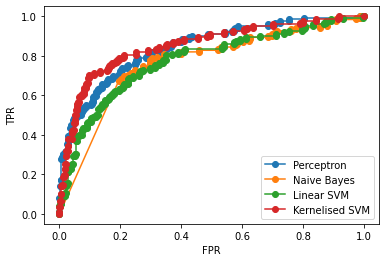

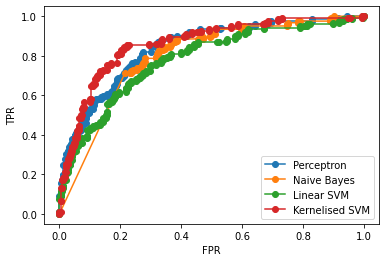

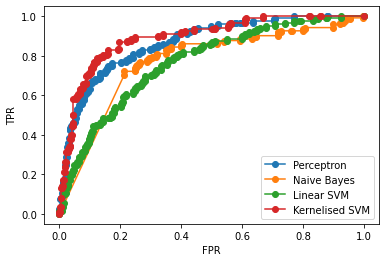

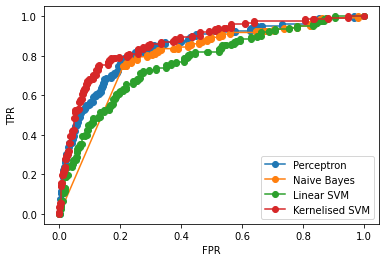

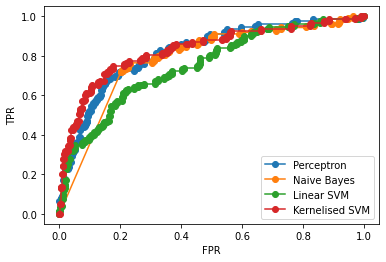

In [97]:
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    
    # ROC curve for the different classifiers
    
    # Perceptron
    knn = Perceptron(eta0=0.1,random_state=1)
    knn.fit(Xtr,ytr)
    df_per=knn.decision_function(Xv)
    fpr_p,tpr_p,tt_p = roc_curve(yv, df_per)
    roc_auc = auc(fpr_p, tpr_p)
    
    # Naive Bayes
    knb = GaussianNB()
    knb.fit(Xtr,ytr)
    pr_nb=knb.predict_proba(Xv)
    fpr_nb,tpr_nb,tt_nb = roc_curve(yv, pr_nb[:,1])
    roc_auc = auc(fpr_nb, tpr_nb)  
    
    # Linear SVM
    knsv = SVC(C = 1.0, class_weight = 'balanced',kernel='linear')
    knsv.fit(Xtr,ytr)
    df_ls=knsv.decision_function(Xv)
    fpr_l,tpr_l,tt_l= roc_curve(yv, df_ls)
    roc_auc = auc(fpr_l, tpr_l)
    
    # Kernelised SVM
    z = SVC(C = 1.0, kernel = 'poly', gamma = 1.0,  class_weight = 'balanced')
    z.fit(Xtr,ytr)
    df_ks=z.decision_function(Xv)
    fpr_k,tpr_k,tt_k = roc_curve(yv, df_ks)
    roc_auc = auc(fpr_k, tpr_k)
    
    # ROC curve plot
    plt.figure()
    plt.plot(fpr_p,tpr_p,'o-',label='Perceptron');plt.xlabel('FPR');plt.ylabel('TPR')
    plt.plot(fpr_nb,tpr_nb,'o-',label='Naive Bayes');plt.xlabel('FPR');plt.ylabel('TPR')
    plt.plot(fpr_l,tpr_l,'o-',label='Linear SVM');plt.xlabel('FPR');plt.ylabel('TPR')
    plt.plot(fpr_k,tpr_k,'o-',label='Kernelised SVM');plt.xlabel('FPR');plt.ylabel('TPR')
    plt.legend()


### (iv) Plot the PR curves of all classifier on the same axes for comparison.


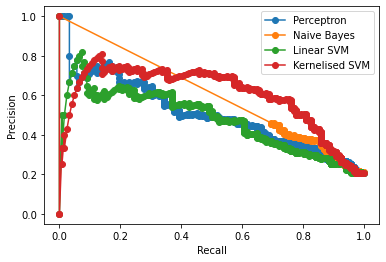

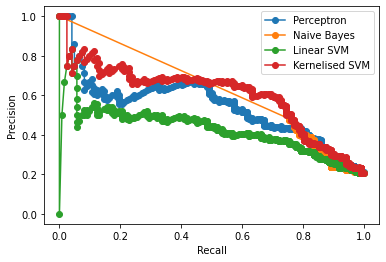

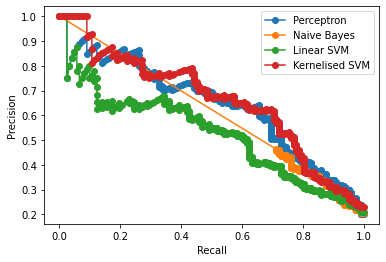

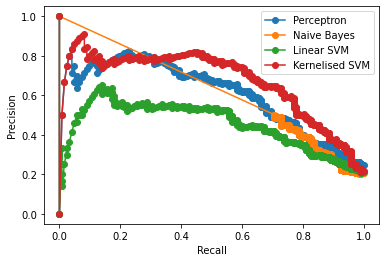

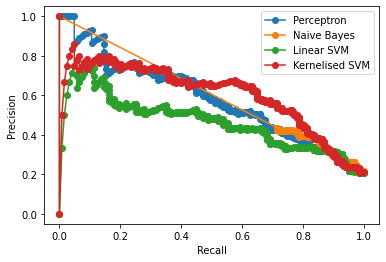

In [98]:
for i,(tr_idx, v_idx) in enumerate(skf.split(xtrain, ytrain)):
    Xtr, Xv = xtrain[tr_idx], xtrain[v_idx]
    ytr, yv = ytrain[tr_idx], ytrain[v_idx]
    
    # PR curve for the different classifiers

    # Perceptron
    knprc = Perceptron(eta0=0.1,random_state=1)
    knprc.fit(Xtr,ytr)
    df_prc=knprc.decision_function(Xv)
    P_p,R_p,tt_p = precision_recall_curve(yv, df_prc)
    pr_auc = average_precision_score(yv, df_prc)
    
    # Naive Bayes
    knbp = GaussianNB()
    knbp.fit(Xtr,ytr)
    prc_nb=knb.predict_proba(Xv)
    P_nb,R_nb,tt_nb = precision_recall_curve(yv, prc_nb[:,1])
    pr_auc = average_precision_score(yv, prc_nb[:,1])
    
    # Linear SVM
    knsp = SVC(C = 1.0, class_weight = 'balanced',kernel='linear')
    knsp.fit(Xtr,ytr)
    prc_ls=knsp.decision_function(Xv)
    P_sv,R_sv,tt_sv = precision_recall_curve(yv, prc_ls)
    pr_auc = average_precision_score(yv, prc_ls)
    
    # Kernelised SVM
    kprc = SVC(C = 1.0, kernel = 'poly', gamma = 1.0,  class_weight = 'balanced')
    kprc.fit(Xtr,ytr)
    df_kprc=kprc.decision_function(Xv)
    P_ks,R_ks,tt_ks = precision_recall_curve(yv, df_kprc)
    pr_auc = average_precision_score(yv, df_kprc)
    
    # PR curve plot
    plt.figure()
    plt.plot(R_p,P_p,'o-',label='Perceptron');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid()
    plt.plot(R_nb,P_nb,'o-',label='Naive Bayes');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid()
    plt.plot(R_sv,P_sv,'o-',label='Linear SVM');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid()
    plt.plot(R_ks,P_ks,'o-',label='Kernelised SVM');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid()
    plt.legend()

### (v) Write your observations about the ROC and PR curves.

### A. ROC curve: The area under the curve is the highest for the Kernelised SVM model indicating that this model performs the best whereas the are under the curve is the lowest for the Linear SVM indicating that this model performs the worst.
### PR curve: The area under the curve is the highest for the Kernelised SVM model indicating that this model performs the best whereas the are under the curve is the lowest for the Perceptron and Linear SVM indicating that this model performs the worst.

## Question 4

### (i) Reduce the number of dimensions of the training data using PCA to 2 and plot a scatter plot of the training data showing examples of each class in a different color. What are your observations about the data based on this plot?

In [99]:
# dimensions 
dr = 2

# performing PCA and reducing the dimensions to 2
pca = PCA(n_components=dr)

# fitting the training data using pca.fit
pca.fit(xtrain)

# transforimg the training data with number of dimensions=2
projected = pca.transform(xtrain)

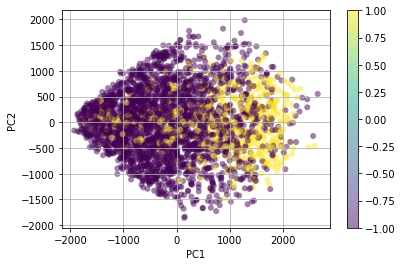

In [100]:
# Scatter plot of the training data

# first principal component
i1 = 0 

# second principal component
i2 = 1 

# scatter plot
plt.scatter(projected[:, i1], projected[:, i2],
            c=ytrain, edgecolor='none', alpha=0.5)

plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

### A. There are more negative classes in the training data. The negative and positive classes are also overlapping with each other as observed in the scatter plot.

### (ii) Reduce the number of dimensions of the training and test data together using PCA to 2 and plot a scatter plot of the training and test data showing examples of each set  in a different color (or marker style). What are your observations about the data based on this plot?

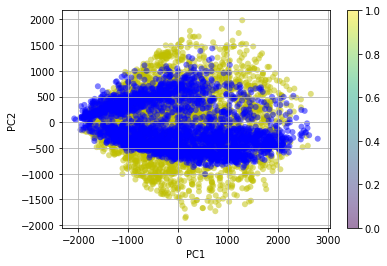

In [101]:
# transforimg the testing data with number of dimensions=2
projected1 = pca.transform(xtest)

# first principal component
i1 = 0 

# second principal component
i2 = 1 

# plotting the training dataset
plt.scatter(projected[:, i1], projected[:, i2],
            c='y', edgecolor='none', alpha=0.5) 

# plotting the testing dataset
plt.scatter(projected1[:, i1], projected1[:, i2],
            c='b', edgecolor='none', alpha=0.5) 
plt.grid()            
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

### A. From the scatter plot, we observe that the training data is more scattered compared to the testing data.

### (iii) Plot the scree graph of PCA and find the number of dimensions that explain 95% variance in the training set.

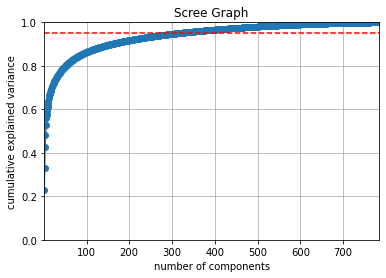

In [102]:
# dimensions=784 as the data has 784 images
pca784 = PCA(n_components=784)

# training PCA
pca784.fit(xtrain) 

# projecting the data onto principal components
projected = pca784.transform(xtrain)

# plotting the cummulatove explained variance and the components
plt.plot(np.arange(len(pca784.explained_variance_ratio_))+1,np.cumsum(pca784.explained_variance_ratio_),'o-') #plot the scree graph

# plotting the 95% variance line
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axis([1,len(pca784.explained_variance_ratio_),0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Scree Graph')
plt.grid()


In [103]:
# setting dimensions to 0.95
pca_95 = PCA(n_components=0.95)

# training PCA
pca_95.fit(xtrain) 

# projecting the data onto principal components
projected = pca_95.transform(xtrain) 

# number of components with 95% variance
pca_95.n_components_

314

### The red dotted line is the 95% variance in the training dataset and 314 dimensions explain the 95% variance in the training dataset.

### (iv) Reduce the number of dimensions of the data using PCA and perform classification.  What is the (optimal) cross-validation performance of a Kernelized SVM classification with PCA? Remember to perform hyperparameter optimization!


In [104]:
# setting the number of dimensions=314 and performing PCA
pca_314 = PCA(n_components=314) 

# training PCA
pca_314.fit(xtrain) 

# projecting the data onto principal components
projected = pca_314.transform(xtrain) 
print(xtrain.shape)
print(projected.shape)

(3000, 784)
(3000, 314)


In [105]:
# splitting the data
Xtr,Xv,ytr,yv=train_test_split(projected,ytrain,test_size=0.4,random_state=0)

# performing Kernelised SVM classification
ker=SVC(kernel = 'rbf', class_weight = 'balanced')

# parameters for grid search
param_grid={'C': [0.1,1,10,100], 
            'gamma': [0.1,0.01,0.001],
           'kernel':['rbf','poly']}

# performing grid search cross validation to find the best hyperparameters
gridsearch=GridSearchCV(estimator=ker,
                        param_grid=param_grid,
                        scoring='f1',
                        refit=True)

# fitting the best parameters found by the grid search
gridsearch.fit(Xtr, ytr)

# predictions
predict_ks1 = gridsearch.predict(Xv)

# decision function
df_ksp = gridsearch.decision_function(Xv)

# accuracy
baccuracy=gridsearch.best_score_
print('Accuracy:',baccuracy)

# best parameters
bparameters=gridsearch.best_params_
print('Best parameters:',bparameters)

Accuracy: 0.5437215666704579
Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}


In [106]:
# Performance metrics of the above model

# accuracy
a1=accuracy_score(yv,predict_ks1)

# balanced accuracy
ba1=balanced_accuracy_score(yv,predict_ks1)

# PR
prec=average_precision_score(yv,df_ksp)

# ROC
fpr,tpr,tt=roc_curve(yv,df_ksp)
roc=auc(fpr,tpr)

print(tabulate({'Performance Metrics':['Accuracy','Balanced Accuracy','ROC','PR'],
               'Mean':[a1,ba1,prec,roc]},
               headers='keys', 
            tablefmt='grid'))

+-----------------------+----------+
| Performance Metrics   |     Mean |
+=======================+==========+
| Accuracy              | 0.8775   |
+-----------------------+----------+
| Balanced Accuracy     | 0.810849 |
+-----------------------+----------+
| ROC                   | 0.718073 |
+-----------------------+----------+
| PR                    | 0.922616 |
+-----------------------+----------+


# **Question 5**

**Develop an optimal pipeline for classification based on your analysis (Q1-Q4). You are free to use any tools or approaches at your disposal.  However, no external data sources may be used. Describe your pipeline and report your outputs over the test data set. (You are required to submit your prediction file together with the assignment in a zip folder). Your prediction file should be a single column file containing the prediction score of the corresponding example in Xtest (be sure to have the same order as the order of the test examples in Xtest!). Your prediction file should be named by your student ID, e.g., u100011.csv.** 


In [107]:
# splitting the data
Xtr,Xv,ytr,yv=train_test_split(
    xtrain,
    ytrain,
    test_size=0.4,
    random_state=0)

In [108]:
# creating a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC())
])

# fiting the data using the created pipeline
pipe.fit(xtrain, ytrain)
 
print('Training set score: ' + str(pipe.score(xtrain,ytrain)))
print('Test set score: ' + str(pipe.score(Xv,yv)))

Training set score: 0.9476666666666667
Test set score: 0.9616666666666667


In [109]:
# setting parameters
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),Normalizer(), MaxAbsScaler()],
              'svc__C':[0.1,1,10,100], 
              'svc__gamma': [1,0.1,0.01,0.001],
              'svc__kernel':['rbf','poly']
}

# performing grid search to find the best parameters
grid = GridSearchCV(pipe, parameters, cv=2).fit(xtrain, ytrain)
 
print('Training set score: ' + str(grid.score(xtrain, ytrain)))
print('Test set score: ' + str(grid.score(Xv, yv)))

Training set score: 0.9186666666666666
Test set score: 0.9333333333333333


In [110]:
# best parameters
grid.best_params_

{'scaler': Normalizer(), 'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'poly'}

In [111]:
# predicitions of the pipeline 
ypred=grid.predict(xtest)
ypred.astype(int)

array([-1, -1,  1, ..., -1, -1, -1])

In [112]:
# file with predictions
np.savetxt('u2255242.csv',ypred, fmt='%i')

In [113]:
# accuracy of the pipeline
KG=[]

predict_grid=grid.predict(xtrain)
pred=grid.decision_function(xtrain)
    
#Accuracy
kg_accuracy=accuracy_score(ytrain,predict_grid)
KG.append(kg_accuracy)

mean_a_ks=np.mean(KS_A)
print('Accuracy:',np.mean(KG))

Accuracy: 0.9186666666666666


### A. A training set and a testing set were created using datasets that were split into two.  The "test size" argument specifies a validation set size of 40% of the original dataset. Since the random state is set to 0, the split will always be the same when the code is executed with the same input data and setting.
### We then create a pipeline. First, we apply the StandardScaler to the data. Then, we create a Support Vector Machine (SVM) classifier. We then fit the pipeline to our data.
### We create a dictionary "parameters" that specifies the hyperparameters to be tuned using cross-validation for the pipeline and then create a grid search to find the best hyperparameters for our pipeline. Further we can find the best parameters and make predicitions.


# Question 6

**Using the data given to you, consider an alternate classification problem in which the label of an example is based on whether it is a part of the training set (label = -1) or the test set (label = +1). Calculate the average and standard deviation of AUC-ROC using 5-fold stratified cross-validation for a classifier that is trained  to solve this prediction task. What is the implication of this AUC-ROC value? Show code for this analysis and clearly explain your conclusions with supporting evidence.** 

In [114]:
# converting the arrays to pdfs
xtrain_df = pd.DataFrame(xtrain)
xtest_df = pd.DataFrame(xtest)

# combining the two dataframes
x_df=pd.concat([xtrain_df,xtest_df])
x_df=x_df.reset_index(drop=True)

In [115]:
# assinging labels to the dataset
label=[]
for i in range(3000):
    label.extend([-1])
    
for i in range(3000):
    label.extend([+1])
    
df_new=x_df.assign(l=label)

In [116]:
# random shuffling of rows 
dfs = df_new.sample(frac = 1)
dfs

0     1     2     3     4     5     6    7     8     9  ...   775  \
5676   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
2865   0.0  39.0   0.0  16.0   0.0  37.0   0.0  0.0   0.0   0.0  ...   0.0   
303   41.0  25.0   0.0   0.0   0.0  12.0   0.0  0.0  47.0   1.0  ...  26.0   
808    0.0   0.0  20.0  27.0  19.0   4.0   0.0  0.0  11.0   1.0  ...   5.0   
1318   0.0  15.0   3.0   0.0  23.0   4.0  19.0  3.0   0.0  12.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...  ...   ...   ...  ...   ...   
5709   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   1.0   0.0  ...   0.0   
5263   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
1070   0.0  26.0   0.0  40.0  25.0   0.0  11.0  0.0   9.0  15.0  ...  33.0   
4032   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0   0.0  ...   0.0   
2067   0.0   0.0  17.0  12.0   0.0  34.0   0.0  0.0  21.0  12.0  ...   0.0   

       776   777    778    779   780   781   782   783  l  
5676   0.0   0.0   12.0    0.0   0.0   0.0   0.0   0.0  1  
2865  39.0   0.0    0.0    0.0  11.0   0.0  16.0  15.0 -1  
303    0.0  14.0    0.0    0.0  32.0  51.0   0.0   0.0 -1  
808    0.0  32.0   16.0    0.0  29.0   0.0   0.0   0.0 -1  
1318   8.0   0.0    0.0   31.0   3.0   0.0   0.0   2.0 -1  
...    ...   ...    ...    ...   ...   ...   ...   ... ..  
5709   0.0   0.0  108.0  124.0  45.0   0.0   0.0   0.0  1  
5263   0.0   0.0    0.0    0.0   0.0   0.0   0.0   0.0  1  
1070   0.0   8.0    0.0    4.0  42.0   0.0  13.0  12.0 -1  
4032   0.0   0.0    0.0    0.0   0.0   0.0   0.0   0.0  1  
2067  21.0   0.0    9.0   27.0   0.0  26.0   0.0   0.0 -1  

[6000 rows x 785 columns]

In [117]:
# dropping the columns with labels
x=dfs.drop(dfs.columns[-1],axis=1)

# converting dataframe into array
x=np.array(x)

In [118]:
# slelcting all columns except the labels
y=dfs[dfs.columns[-1]]

# converting dataframe into array
y=np.array(y)

In [119]:
# fitting the data to 5-fold stratified cross validation
skf = StratifiedKFold(n_splits=5,shuffle = True)  

Xtr,Xv,ytr,yv=train_test_split(
    x,
    y,
    test_size=0.4,
    random_state=0)

In [120]:
# Kernelised SVM

ksd_ROC=[]


for i,(tr_idx, v_idx) in enumerate(skf.split(x, y)):
    Xtr, Xv = x[tr_idx], x[v_idx]
    ytr, yv = y[tr_idx], y[v_idx]
    ksd = SVC(C = 1.0, kernel = 'poly', gamma = 1.0,  class_weight = 'balanced')
    ksd.fit(Xtr,ytr)
    predict_ksd=ksd.predict(Xv)
    ksd_df=ksd.decision_function(Xv)
    
    fpr_ksd,tpr_ksd,tt_ksd = roc_curve(yv, ksd_df)
    roc_auc = auc(fpr_ksd, tpr_ksd)
    
    # ROC
    roc_ksd=roc_auc_score(yv,ksd_df)
    ksd_ROC.append(roc_ksd)
    

# Mean ROC
mean_roc_ksd=np.mean(ksd_ROC)
print('Mean ROC:',np.mean(ksd_ROC))

# Std Dev ROC                         
stdev_roc_ksd=np.std(ksd_ROC)
print('Std Dev ROC:',np.std(ksd_ROC))

Mean ROC: 0.9840672222222222
Std Dev ROC: 0.006846773007576974


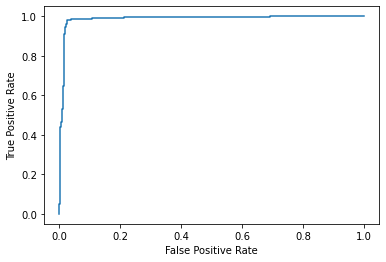

In [121]:
# plotting ROC 
plt.figure()
plt.plot(fpr_ksd, tpr_ksd)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### A. The ROC is close to 1 and hence, it is a perfect classifier.